<p style="text-align: center;">
    <span style="font-size: xx-large; font-weight: bold; color: red;">
        PROJET 7 :
        Implementez un modèle de scoring
    </span>
</p>  

__Sommaire__

**Partie 1 : Importation des bibliothèques**

**Partie 2 : Analyse exploratoire des données**
- <a href="#C0">Fonctions utiles</a>
- <a href="#C1">Chargement des fichiers</a>
- <a>Prétraitements des fichiers</a>
    - <a href="#C2"> Test et validation</a>
    - <a href="#C3"> bureau et bureau_balance</a>
    - <a href="#C4"> previous_application</a>
    - <a href="#C5"> posh_cash_balance</a>
    - <a href="#C6"> installments_payement</a>
    - <a href="#C7"> credit_card_balance</a>
- <a>Feature engineering (conservation des features qui ont moins de 80% de données manquantes)</a>
    - <a href="#C8"> df </a>
    - <a href="#C9"> bureau_agg</a>
    - <a href="#C10">previous_applications_agg </a>
    - <a href="#C11">installments_payments_agg </a>
    - <a href="#C12">credit_card_balance_agg</a>
    - <a href="#C13">home_credit </a>
- <a>Exploration variable cible</a>
    - <a href="#C14">feature target </a>

**Partie 3 : Modélisation**   
- <a href="#C15">Prétraitement des données </a>
- <a href="#C16">Traitement données train avec/sans réequilibrage</a>
- <a href="#C17">Modelisation</a>
- <a href="#C18">Configuration environnement MLflow et entrainement modèle</a>
- <a href="#C19">Optimisation des hyperparametres</a>
- <a href="#C20">Evaluation des modèles</a>
- <a href="#C21">Resultat des modèles</a>

**Partie 4 : Analyse des features du meilleur modèle**   
- <a>Analyse local et global à partir de shap</a>

**Partie 5 : Data drift**   
- <a>generation rapport data drift à partir d’evidently </a>

# <span style="color:green; font-weight:bold;">Partie 1 : Importation des bibliothèques</span>

In [305]:
# Standard Libraries
import os
import time
import gc
import re
from contextlib import contextmanager
import warnings

# Data Manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn Modules
from sklearn.model_selection import (
    train_test_split, StratifiedKFold, KFold, cross_val_score, RandomizedSearchCV
)
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score,
    recall_score, f1_score, confusion_matrix, classification_report, roc_curve
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# LightGBM
import lightgbm as lgb
from lightgbm import LGBMClassifier

# Hyperparameter Tuning
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK

# MLflow
import mlflow
import mlflow.sklearn

# Imbalanced Learning
from imblearn.over_sampling import ADASYN

# SHAP
import shap

# Evidently (for Data Drift Analysis)
from evidently.report import Report
from evidently.metric_preset import DataDriftPreset

# Joblib (for Model Saving/Loading)
import joblib

# Warnings Configuration
warnings.simplefilter(action='ignore', category=FutureWarning)

# mlflow ui --port 6000
#kill -9 PID

# <span style="color:green; font-weight:bold;">Partie 2 : Analyse exploratoire des données</span>

# <a name="C0"><span style="text-decoration: underline;">Fonctions utiles</span></a>

In [308]:
# Function to calculate missing values by column# Funct 
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [309]:
# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

# <a name="C1"><span style="text-decoration: underline;">Chargement des fichiers</span></a>

In [311]:
# Charger les fichiers en utilisant dask
sample_submission = pd.read_csv("/Users/Nelly/Desktop/projet 7/data/sample_submission.csv")
home_credit = pd.read_csv("/Users/Nelly/Desktop/projet 7/data/HomeCredit_columns_description.csv", encoding="ISO-8859-1")

# <a name="C2"><span style="text-decoration: underline;">Prétraitement des fichiers de validation et d'entrainement</span></a>

In [313]:
# Prétraitement des fichiers application_train.csv et application_test.csv sans limitation de lignes
def application_train_test(nan_as_category=False):
    # Lire les données complètes et fusionner
    df = pd.read_csv("/Users/Nelly/Desktop/projet 7/data/application_train.csv")
    test_df = pd.read_csv("/Users/Nelly/Desktop/projet 7/data/application_test.csv")
    print("Échantillons d'entraînement : {}, échantillons de test : {}".format(len(df), len(test_df)))
    df = df.append(test_df).reset_index(drop=True)
    
    # Optionnel : Supprimer les applications avec CODE_GENDER 'XNA' (ensemble d'entraînement)
    df = df[df['CODE_GENDER'] != 'XNA']
    
    # Caractéristiques catégorielles avec encodage binaire (0 ou 1 ; deux catégories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
        
    # Caractéristiques catégorielles avec encodage One-Hot
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    # Valeurs NaN pour DAYS_EMPLOYED : 365.243 -> NaN
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)
    
    # Quelques nouvelles caractéristiques simples (pourcentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    
    del test_df
    gc.collect()
    return df

In [314]:
# Appel de la fonction pour voir le résultat
df = application_train_test(nan_as_category=True)
df.head()

Échantillons d'entraînement : 307511, échantillons de test : 48744


,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,WALLSMATERIAL_MODE_Wooden,WALLSMATERIAL_MODE_nan,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,EMERGENCYSTATE_MODE_nan,DAYS_EMPLOYED_PERC,INCOME_CREDIT_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE
0,100002,1.0,0,0,0,0,202500.0,406597.5,24700.5,351000.0,...,0,0,1,0,0,0.067329,0.498036,202500.0,0.121978,0.060749
1,100003,0.0,1,0,1,0,270000.0,1293502.5,35698.5,1129500.0,...,0,0,1,0,0,0.070862,0.208736,135000.0,0.132217,0.027598
2,100004,0.0,0,1,0,0,67500.0,135000.0,6750.0,135000.0,...,0,1,0,0,1,0.011814,0.500000,67500.0,0.100000,0.050000
3,100006,0.0,1,0,0,0,135000.0,312682.5,29686.5,297000.0,...,0,1,0,0,1,0.159905,0.431748,67500.0,0.219900,0.094941
4,100007,0.0,0,0,0,0,121500.0,513000.0,21865.5,513000.0,...,0,1,0,0,1,0.152418,0.236842,121500.0,0.179963,0.042623


In [315]:
print('Training/test data shape: ', df.shape)

Training/test data shape:  (356251, 260)


In [316]:
# Missing values statistics
missing_values = missing_values_table(df)
missing_values.head(20)

Your selected dataframe has 260 columns.
There are 67 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_AVG,248357,69.7
COMMONAREA_MEDI,248357,69.7
COMMONAREA_MODE,248357,69.7
NONLIVINGAPARTMENTS_MODE,246859,69.3
NONLIVINGAPARTMENTS_MEDI,246859,69.3
NONLIVINGAPARTMENTS_AVG,246859,69.3
LIVINGAPARTMENTS_MODE,242977,68.2
LIVINGAPARTMENTS_AVG,242977,68.2
LIVINGAPARTMENTS_MEDI,242977,68.2
FLOORSMIN_AVG,241106,67.7


Dans des travaux ultérieurs, nous utiliserons des modèles tels que XGBoost qui peuvent gérer les valeurs manquantes sans avoir besoin d’imputation.

In [318]:
# nombre des differents types
df.dtypes.value_counts()

uint8      146
float64     72
int64       42
dtype: int64

# <a name="C3"><span style="text-decoration: underline;">Prétraitement des données bureau et bureau_balance</span></a>

In [320]:
# Prétraitement des fichiers bureau.csv et bureau_balance.csv
def bureau_and_balance(num_rows=None, nan_as_category=True):
    bureau = pd.read_csv("/Users/Nelly/Desktop/projet 7/data/bureau.csv")
    bb = pd.read_csv("/Users/Nelly/Desktop/projet 7/data/bureau_balance.csv")
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance : Effectuer des agrégations et fusionner avec bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace=True)
    del bb, bb_agg
    gc.collect()
    
    # Caractéristiques numériques de bureau et bureau_balance
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Caractéristiques catégorielles de bureau et bureau_balance
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau : Crédits actifs - en utilisant uniquement les agrégations numériques
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau : Crédits clôturés - en utilisant uniquement les agrégations numériques
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

In [321]:
# Charger et afficher le DataFrame résultant
bureau_agg = bureau_and_balance()

In [322]:
bureau_agg.head() 

,BURO_DAYS_CREDIT_MIN,BURO_DAYS_CREDIT_MAX,BURO_DAYS_CREDIT_MEAN,BURO_DAYS_CREDIT_VAR,BURO_DAYS_CREDIT_ENDDATE_MIN,BURO_DAYS_CREDIT_ENDDATE_MAX,BURO_DAYS_CREDIT_ENDDATE_MEAN,BURO_DAYS_CREDIT_UPDATE_MEAN,BURO_CREDIT_DAY_OVERDUE_MAX,BURO_CREDIT_DAY_OVERDUE_MEAN,...,CLOSED_AMT_CREDIT_SUM_OVERDUE_MEAN,CLOSED_AMT_CREDIT_SUM_LIMIT_MEAN,CLOSED_AMT_CREDIT_SUM_LIMIT_SUM,CLOSED_AMT_ANNUITY_MAX,CLOSED_AMT_ANNUITY_MEAN,CLOSED_CNT_CREDIT_PROLONG_SUM,CLOSED_MONTHS_BALANCE_MIN_MIN,CLOSED_MONTHS_BALANCE_MAX_MAX,CLOSED_MONTHS_BALANCE_SIZE_MEAN,CLOSED_MONTHS_BALANCE_SIZE_SUM
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,-1572,-49,-735.000000,240043.666667,-1329.0,1778.0,82.428571,-93.142857,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-51.0,0.0,35.0,140.0
100002,-1437,-103,-874.000000,186150.000000,-1072.0,780.0,-349.000000,-499.875000,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-47.0,0.0,15.0,90.0
100003,-2586,-606,-1400.750000,827783.583333,-2434.0,1216.0,-544.500000,-816.000000,0,0.0,...,0.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,0.0
100004,-1326,-408,-867.000000,421362.000000,-595.0,-382.0,-488.500000,-532.000000,0,0.0,...,0.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,0.0
100005,-373,-62,-190.666667,26340.333333,-128.0,1324.0,439.333333,-54.333333,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-12.0,0.0,13.0,13.0


In [323]:
print('bureau/bureau_balance : ', bureau_agg.shape)

bureau/bureau_balance :  (305811, 116)


In [324]:
# Missing values statistics
missing_values = missing_values_table(bureau_agg)
missing_values.head()

Your selected dataframe has 116 columns.
There are 78 columns that have missing values.


,Missing Values,% of Total Values
ACTIVE_AMT_ANNUITY_MEAN,213085,69.7
ACTIVE_AMT_ANNUITY_MAX,213085,69.7
CLOSED_AMT_ANNUITY_MEAN,210614,68.9
CLOSED_AMT_ANNUITY_MAX,210614,68.9
ACTIVE_MONTHS_BALANCE_MIN_MIN,194662,63.7


# <a name="C4"><span style="text-decoration: underline;">Prétraitement des données de previous_application</span></a>

In [326]:
# Fonction pour l'encodage One-Hot
def one_hot_encoder(df, nan_as_category=True):
    original_columns = list(df.columns)
    df = pd.get_dummies(df, dummy_na=nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

# Prétraitement de previous_applications.csv
def previous_applications(nan_as_category=True):
    prev = pd.read_csv("/Users/Nelly/Desktop/projet 7/data/previous_application.csv")
    prev, cat_cols = one_hot_encoder(prev, nan_as_category=True)
    
    # Valeurs de 365.243 jours -> NaN
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace=True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace=True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace=True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace=True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace=True)
    
    # Ajouter une caractéristique : pourcentage de la valeur demandée / valeur reçue
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    
    # Caractéristiques numériques des demandes précédentes
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Caractéristiques catégorielles des demandes précédentes
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    
    # Demandes précédentes : Demandes approuvées - uniquement les caractéristiques numériques
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    
    # Demandes précédentes : Demandes refusées - uniquement les caractéristiques numériques
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

In [327]:
# Exécuter la fonction et afficher le DataFrame
previous_applications_agg = previous_applications()

In [328]:
previous_applications_agg.head()

,PREV_AMT_ANNUITY_MIN,PREV_AMT_ANNUITY_MAX,PREV_AMT_ANNUITY_MEAN,PREV_AMT_APPLICATION_MIN,PREV_AMT_APPLICATION_MAX,PREV_AMT_APPLICATION_MEAN,PREV_AMT_CREDIT_MIN,PREV_AMT_CREDIT_MAX,PREV_AMT_CREDIT_MEAN,PREV_APP_CREDIT_PERC_MIN,...,REFUSED_HOUR_APPR_PROCESS_START_MAX,REFUSED_HOUR_APPR_PROCESS_START_MEAN,REFUSED_RATE_DOWN_PAYMENT_MIN,REFUSED_RATE_DOWN_PAYMENT_MAX,REFUSED_RATE_DOWN_PAYMENT_MEAN,REFUSED_DAYS_DECISION_MIN,REFUSED_DAYS_DECISION_MAX,REFUSED_DAYS_DECISION_MEAN,REFUSED_CNT_PAYMENT_MEAN,REFUSED_CNT_PAYMENT_SUM
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,3951.000,3951.000,3951.000,24835.5,24835.5,24835.50,23787.0,23787.0,23787.00,1.044079,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100002,9251.775,9251.775,9251.775,179055.0,179055.0,179055.00,179055.0,179055.0,179055.00,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100003,6737.310,98356.995,56553.990,68809.5,900000.0,435436.50,68053.5,1035882.0,484191.00,0.868825,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100004,5357.250,5357.250,5357.250,24282.0,24282.0,24282.00,20106.0,20106.0,20106.00,1.207699,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100005,4813.200,4813.200,4813.200,0.0,44617.5,22308.75,0.0,40153.5,20076.75,1.111173,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [329]:
print('previous : ', previous_applications_agg.shape)

previous :  (338857, 249)


In [330]:
# Missing values statistics
missing_values = missing_values_table(previous_applications_agg)
missing_values.head()

Your selected dataframe has 249 columns.
There are 77 columns that have missing values.


,Missing Values,% of Total Values
REFUSED_RATE_DOWN_PAYMENT_MAX,286252,84.5
REFUSED_RATE_DOWN_PAYMENT_MIN,286252,84.5
REFUSED_AMT_DOWN_PAYMENT_MEAN,286252,84.5
REFUSED_AMT_DOWN_PAYMENT_MAX,286252,84.5
REFUSED_AMT_DOWN_PAYMENT_MIN,286252,84.5


# <a name="C5"><span style="text-decoration: underline;">Prétraitement des données de POS_CASH_balance</span></a>

In [332]:
# Prétraitement de POS_CASH_balance.csv
def pos_cash(num_rows=None, nan_as_category=True):
    pos = pd.read_csv("/Users/Nelly/Desktop/projet 7/data/POS_CASH_balance.csv")
    pos, cat_cols = one_hot_encoder(pos, nan_as_category=True)
    
    # Caractéristiques
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    
    # Compter le nombre de comptes POS cash
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg

In [333]:
# Charger et visualiser le DataFrame
pos_cash_agg = pos_cash()

In [334]:
pos_cash_agg.head()

,POS_MONTHS_BALANCE_MAX,POS_MONTHS_BALANCE_MEAN,POS_MONTHS_BALANCE_SIZE,POS_SK_DPD_MAX,POS_SK_DPD_MEAN,POS_SK_DPD_DEF_MAX,POS_SK_DPD_DEF_MEAN,POS_NAME_CONTRACT_STATUS_Active_MEAN,POS_NAME_CONTRACT_STATUS_Amortized debt_MEAN,POS_NAME_CONTRACT_STATUS_Approved_MEAN,POS_NAME_CONTRACT_STATUS_Canceled_MEAN,POS_NAME_CONTRACT_STATUS_Completed_MEAN,POS_NAME_CONTRACT_STATUS_Demand_MEAN,POS_NAME_CONTRACT_STATUS_Returned to the store_MEAN,POS_NAME_CONTRACT_STATUS_Signed_MEAN,POS_NAME_CONTRACT_STATUS_XNA_MEAN,POS_NAME_CONTRACT_STATUS_nan_MEAN,POS_COUNT
SK_ID_CURR,,,,,,,,,,,,,,,,,,
100001,-53,-72.555556,9,7,0.777778,7,0.777778,0.777778,0.0,0.0,0.0,0.222222,0.0,0.0,0.000000,0.0,0.0,9
100002,-1,-10.000000,19,0,0.000000,0,0.000000,1.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,19
100003,-18,-43.785714,28,0,0.000000,0,0.000000,0.928571,0.0,0.0,0.0,0.071429,0.0,0.0,0.000000,0.0,0.0,28
100004,-24,-25.500000,4,0,0.000000,0,0.000000,0.750000,0.0,0.0,0.0,0.250000,0.0,0.0,0.000000,0.0,0.0,4
100005,-15,-20.000000,11,0,0.000000,0,0.000000,0.818182,0.0,0.0,0.0,0.090909,0.0,0.0,0.090909,0.0,0.0,11


In [335]:
print('pos_cash : ', pos_cash_agg.shape)

pos_cash :  (337252, 18)


In [336]:
# Missing values statistics
missing_values = missing_values_table(pos_cash_agg)
missing_values.head()

Your selected dataframe has 18 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


# <a name="C6"><span style="text-decoration: underline;">Prétraitement des données installments_payments</span></a>

In [338]:
# Fonction pour l'encodage One-Hot
def one_hot_encoder(df, nan_as_category=True):
    original_columns = list(df.columns)
    df = pd.get_dummies(df, dummy_na=nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

# Prétraitement de installments_payments.csv
def installments_payments(nan_as_category=True):
    # Lire les données de installments_payments
    ins = pd.read_csv("/Users/Nelly/Desktop/projet 7/data/installments_payments.csv")
    ins, cat_cols = one_hot_encoder(ins, nan_as_category=True)
    
    # Pourcentage et différence payés dans chaque versement (montant payé et valeur du versement)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    
    # Jours de retard et jours avant échéance (pas de valeurs négatives)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    
    # Caractéristiques : effectuer des agrégations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    
    # Compter le nombre de comptes de versements
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    
    # Libérer la mémoire
    del ins
    gc.collect()
    
    return ins_agg

In [339]:
# Charger et visualiser le DataFrame
installments_payments_agg = installments_payments()

In [340]:
installments_payments_agg.head()

,INSTAL_NUM_INSTALMENT_VERSION_NUNIQUE,INSTAL_DPD_MAX,INSTAL_DPD_MEAN,INSTAL_DPD_SUM,INSTAL_DBD_MAX,INSTAL_DBD_MEAN,INSTAL_DBD_SUM,INSTAL_PAYMENT_PERC_MAX,INSTAL_PAYMENT_PERC_MEAN,INSTAL_PAYMENT_PERC_SUM,...,INSTAL_AMT_INSTALMENT_MEAN,INSTAL_AMT_INSTALMENT_SUM,INSTAL_AMT_PAYMENT_MIN,INSTAL_AMT_PAYMENT_MAX,INSTAL_AMT_PAYMENT_MEAN,INSTAL_AMT_PAYMENT_SUM,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,INSTAL_COUNT
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,2,11.0,1.571429,11.0,36.0,8.857143,62.0,1.0,1.0,7.0,...,5885.132143,41195.925,3951.000,17397.900,5885.132143,41195.925,-1628.0,-2195.000000,-15365.0,7
100002,2,0.0,0.000000,0.0,31.0,20.421053,388.0,1.0,1.0,19.0,...,11559.247105,219625.695,9251.775,53093.745,11559.247105,219625.695,-49.0,-315.421053,-5993.0,19
100003,2,0.0,0.000000,0.0,14.0,7.160000,179.0,1.0,1.0,25.0,...,64754.586000,1618864.650,6662.970,560835.360,64754.586000,1618864.650,-544.0,-1385.320000,-34633.0,25
100004,2,0.0,0.000000,0.0,11.0,7.666667,23.0,1.0,1.0,3.0,...,7096.155000,21288.465,5357.250,10573.965,7096.155000,21288.465,-727.0,-761.666667,-2285.0,3
100005,2,1.0,0.111111,1.0,37.0,23.666667,213.0,1.0,1.0,9.0,...,6240.205000,56161.845,4813.200,17656.245,6240.205000,56161.845,-470.0,-609.555556,-5486.0,9


In [341]:
print('installments payments : ', installments_payments_agg.shape)

installments payments :  (339587, 26)


In [342]:
# Missing values statistics
missing_values = missing_values_table(installments_payments_agg)
missing_values.head()

Your selected dataframe has 26 columns.
There are 12 columns that have missing values.


,Missing Values,% of Total Values
INSTAL_PAYMENT_PERC_VAR,996,0.3
INSTAL_PAYMENT_DIFF_VAR,977,0.3
INSTAL_PAYMENT_PERC_MEAN,28,0.0
INSTAL_PAYMENT_PERC_SUM,19,0.0
INSTAL_PAYMENT_PERC_MAX,9,0.0


# <a name="C7"><span style="text-decoration: underline;">Prétraitement des données credit_card_balance</span></a>

In [344]:
# Prétraitement de credit_card_balance.csv
def credit_card_balance(nan_as_category=True):
    cc = pd.read_csv("/Users/Nelly/Desktop/projet 7/data/credit_card_balance.csv")
    cc, cat_cols = one_hot_encoder(cc, nan_as_category=True)
    
    # Agrégations générales
    cc.drop(['SK_ID_PREV'], axis=1, inplace=True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    
    # Compter le nombre de lignes de carte de crédit
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    
    del cc
    gc.collect()
    return cc_agg

In [345]:
# Charger et visualiser le DataFrame
credit_card_balance_agg = credit_card_balance()
credit_card_balance_agg.head()

,CC_MONTHS_BALANCE_MIN,CC_MONTHS_BALANCE_MAX,CC_MONTHS_BALANCE_MEAN,CC_MONTHS_BALANCE_SUM,CC_MONTHS_BALANCE_VAR,CC_AMT_BALANCE_MIN,CC_AMT_BALANCE_MAX,CC_AMT_BALANCE_MEAN,CC_AMT_BALANCE_SUM,CC_AMT_BALANCE_VAR,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100006,-6,-1,-3.5,-21,3.5,0.0,0.00,0.000000,0.000,0.000000e+00,...,0,0.0,0,0.0,0,0,0.0,0,0.0,6
100011,-75,-2,-38.5,-2849,462.5,0.0,189000.00,54482.111149,4031676.225,4.641321e+09,...,0,0.0,0,0.0,0,0,0.0,0,0.0,74
100013,-96,-1,-48.5,-4656,776.0,0.0,161420.22,18159.919219,1743352.245,1.869473e+09,...,0,0.0,0,0.0,0,0,0.0,0,0.0,96
100021,-18,-2,-10.0,-170,25.5,0.0,0.00,0.000000,0.000,0.000000e+00,...,0,0.0,0,0.0,0,0,0.0,0,0.0,17
100023,-11,-4,-7.5,-60,6.0,0.0,0.00,0.000000,0.000,0.000000e+00,...,0,0.0,0,0.0,0,0,0.0,0,0.0,8


In [346]:
print('credit_card_balance_agg : ', credit_card_balance_agg.shape)

credit_card_balance_agg :  (103558, 141)


In [347]:
# Missing values statistics
missing_values = missing_values_table(credit_card_balance_agg)
missing_values.head()

Your selected dataframe has 141 columns.
There are 49 columns that have missing values.


,Missing Values,% of Total Values
CC_AMT_PAYMENT_CURRENT_VAR,31956,30.9
CC_CNT_DRAWINGS_POS_CURRENT_VAR,31866,30.8
CC_AMT_DRAWINGS_OTHER_CURRENT_VAR,31866,30.8
CC_CNT_DRAWINGS_OTHER_CURRENT_VAR,31866,30.8
CC_CNT_DRAWINGS_ATM_CURRENT_VAR,31866,30.8


**sample_submission**

In [349]:
print('sample_submission : ', sample_submission.shape)

sample_submission :  (48744, 2)


In [350]:
# Missing values statistics
missing_values = missing_values_table(sample_submission)
missing_values.head()

Your selected dataframe has 2 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


**HomeCredit_columns_description**

In [352]:
print('home_credit : ', home_credit.shape)

home_credit :  (219, 5)


In [353]:
# Missing values statistics
missing_values = missing_values_table(home_credit)
missing_values.head()

Your selected dataframe has 5 columns.
There are 1 columns that have missing values.


,Missing Values,% of Total Values
Special,133,60.7


# <a name="C8"><span style="text-decoration: underline;">Traitement données manquantes df</span></a>

les data frames qui ont des données manquantes : 
- df
- bureau_agg
- previous_applications_agg
- installments_payments_agg
- credit_card_balance_agg
- home_credit

In [356]:
# Calculer les statistiques des valeurs manquantes
missing_values = missing_values_table(df)

# Filtrer pour obtenir uniquement les caractéristiques avec plus de 80 % de valeurs manquantes
missing_values_80 = missing_values[missing_values['% of Total Values'] > 80]

# Afficher les premières lignes des colonnes avec plus de 80 % de valeurs manquantes
print(missing_values_80)

Your selected dataframe has 260 columns.
There are 67 columns that have missing values.
Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []


# <a name="C9"><span style="text-decoration: underline;">Traitement données manquantes bureau_agg</span></a>

In [358]:
# Calculer les statistiques des valeurs manquantes
missing_values = missing_values_table(bureau_agg)

# Filtrer pour obtenir uniquement les caractéristiques avec plus de 80 % de valeurs manquantes
missing_values_80 = missing_values[missing_values['% of Total Values'] > 80]

# Afficher les premières lignes des colonnes avec plus de 80 % de valeurs manquantes
print(missing_values_80)

Your selected dataframe has 116 columns.
There are 78 columns that have missing values.
Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []


# <a name="C10"><span style="text-decoration: underline;">Traitement données manquantes previous_applications_agg</span></a>

In [360]:
# Calculer les statistiques des valeurs manquantes
missing_values = missing_values_table(previous_applications_agg)

# Filtrer pour obtenir les caractéristiques avec plus de 80 % de valeurs manquantes
features_to_drop = missing_values[missing_values['% of Total Values'] > 80].index

# Supprimer les colonnes avec plus de 80 % de valeurs manquantes du DataFrame principal
previous_applications_agg_cleaned = previous_applications_agg.drop(columns=features_to_drop)

# Afficher la forme du DataFrame après la suppression
print("DataFrame initial :", previous_applications_agg.shape)
print("DataFrame après suppression des colonnes avec plus de 80 % de valeurs manquantes :", previous_applications_agg_cleaned.shape)

Your selected dataframe has 249 columns.
There are 77 columns that have missing values.
DataFrame initial : (338857, 249)
DataFrame après suppression des colonnes avec plus de 80 % de valeurs manquantes : (338857, 242)


# <a name="C11"><span style="text-decoration: underline;">Traitement données manquantes installments_payments_agg</span></a>

In [362]:
# Calculer les statistiques des valeurs manquantes
missing_values = missing_values_table(installments_payments_agg)

# Filtrer pour obtenir uniquement les caractéristiques avec plus de 80 % de valeurs manquantes
missing_values_80 = missing_values[missing_values['% of Total Values'] > 80]

# Afficher les premières lignes des colonnes avec plus de 80 % de valeurs manquantes
print(missing_values_80)

Your selected dataframe has 26 columns.
There are 12 columns that have missing values.
Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []


# <a name="C12"><span style="text-decoration: underline;">Traitement données manquantes credit_card_balance_agg</span></a>

In [364]:
# Calculer les statistiques des valeurs manquantes
missing_values = missing_values_table(credit_card_balance_agg)

# Filtrer pour obtenir uniquement les caractéristiques avec plus de 80 % de valeurs manquantes
missing_values_80 = missing_values[missing_values['% of Total Values'] > 80]

# Afficher les premières lignes des colonnes avec plus de 80 % de valeurs manquantes
print(missing_values_80)

Your selected dataframe has 141 columns.
There are 49 columns that have missing values.
Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []


# <a name="C13"><span style="text-decoration: underline;">Traitement données manquantes home_credit</span></a>

In [366]:
# Calculer les statistiques des valeurs manquantes
missing_values = missing_values_table(home_credit)

# Filtrer pour obtenir uniquement les caractéristiques avec plus de 80 % de valeurs manquantes
missing_values_80 = missing_values[missing_values['% of Total Values'] > 80]

# Afficher les premières lignes des colonnes avec plus de 80 % de valeurs manquantes
print(missing_values_80)

Your selected dataframe has 5 columns.
There are 1 columns that have missing values.
Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []


# <a name="C14"><span style="text-decoration: underline;">Exploration variable cible (target)</span></a>

In [368]:
df['TARGET'].value_counts()

0.0    282682
1.0     24825
Name: TARGET, dtype: int64

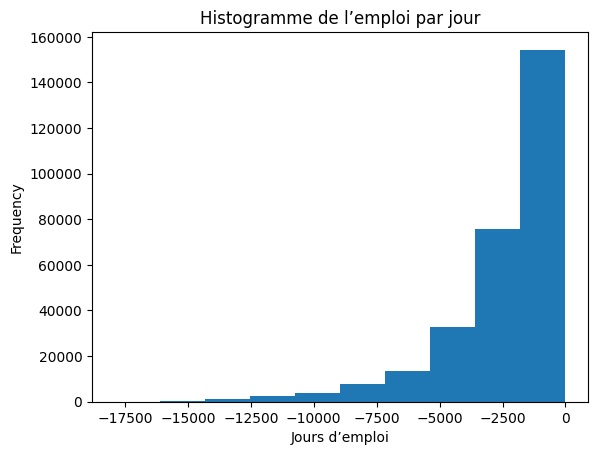

In [369]:
# Create an anomalous flag column
df['DAYS_EMPLOYED_ANOM'] = df["DAYS_EMPLOYED"] == 365243

# Replace the anomalous values with nan
df['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

df['DAYS_EMPLOYED'].plot.hist(title = 'Histogramme de l’emploi par jour');
plt.xlabel('Jours d’emploi');

In [370]:
# Trouver les corrélations avec la cible et trier
correlations = df.corr()['TARGET'].sort_values()

# Afficher les corrélations
print('Corrélations les plus positives :\n', correlations.tail(15))
print('\nCorrélations les plus négatives :\n', correlations.head(15))

Corrélations les plus positives :
 DAYS_LAST_PHONE_CHANGE            0.055219
NAME_INCOME_TYPE_Working          0.057483
REGION_RATING_CLIENT              0.058901
REGION_RATING_CLIENT_W_CITY       0.060895
DAYS_EMPLOYED                     0.074957
DAYS_BIRTH                        0.078242
TARGET                            1.000000
NAME_CONTRACT_TYPE_nan                 NaN
NAME_INCOME_TYPE_nan                   NaN
NAME_EDUCATION_TYPE_nan                NaN
NAME_FAMILY_STATUS_nan                 NaN
NAME_HOUSING_TYPE_nan                  NaN
WEEKDAY_APPR_PROCESS_START_nan         NaN
ORGANIZATION_TYPE_nan                  NaN
DAYS_EMPLOYED_ANOM                     NaN
Name: TARGET, dtype: float64

Corrélations les plus négatives :
 EXT_SOURCE_3                           -0.178926
EXT_SOURCE_2                           -0.160471
EXT_SOURCE_1                           -0.155317
DAYS_EMPLOYED_PERC                     -0.067952
NAME_EDUCATION_TYPE_Higher education   -0.056593
CODE_GENDE

In [371]:
# Informations d'âge dans un DataFrame séparé
age_data = df[['TARGET', 'DAYS_BIRTH']]

# Prendre la valeur absolue de DAYS_BIRTH pour enlever les valeurs négatives, puis convertir en années
age_data['DAYS_BIRTH'] = age_data['DAYS_BIRTH'].abs()  # Cette ligne prend la valeur absolue
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365

# Créer des intervalles d'âge personnalisés de 5 en 5 ans
bins = [20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70]
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins=bins)

# Afficher les premières lignes
print(age_data.head(10))

   TARGET  DAYS_BIRTH  YEARS_BIRTH YEARS_BINNED
0     1.0        9461    25.920548     (25, 30]
1     0.0       16765    45.931507     (45, 50]
2     0.0       19046    52.180822     (50, 55]
3     0.0       19005    52.068493     (50, 55]
4     0.0       19932    54.608219     (50, 55]
5     0.0       16941    46.413699     (45, 50]
6     0.0       13778    37.747945     (35, 40]
7     0.0       18850    51.643836     (50, 55]
8     0.0       20099    55.065753     (55, 60]
9     0.0       14469    39.641096     (35, 40]


In [372]:
# Group by the bin and calculate averages
age_groups  = age_data.groupby('YEARS_BINNED').mean()
age_groups

,TARGET,DAYS_BIRTH,YEARS_BIRTH
YEARS_BINNED,,,
"(20, 25]",0.123036,8538.378305,23.392817
"(25, 30]",0.111442,10158.553997,27.831655
"(30, 35]",0.102814,11856.378412,32.483229
"(35, 40]",0.089416,13708.090454,37.556412
"(40, 45]",0.078491,15497.596332,42.459168
"(45, 50]",0.074171,17323.579317,47.461861
"(50, 55]",0.066968,19193.920120,52.586083
"(55, 60]",0.055316,20982.126230,57.485277
"(60, 65]",0.052737,22779.717434,62.410185


Text(0.5, 1.0, "Défaut de remboursement par groupe d'âge")

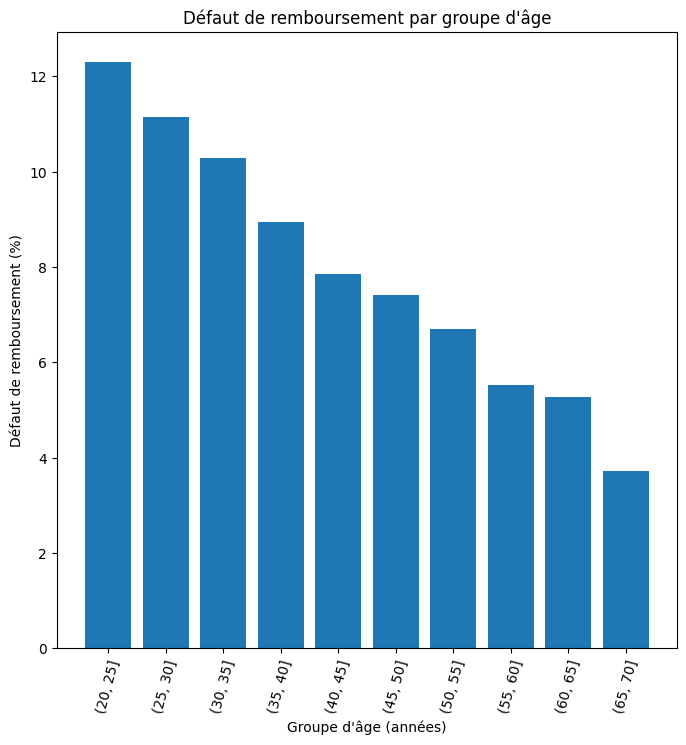

In [373]:
plt.figure(figsize = (8, 8))

# Graphique des tranches d'âge et de la moyenne de la cible sous forme de diagramme à barres
plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])

# Étiquettes du graphique
plt.xticks(rotation = 75)
plt.xlabel('Groupe d\'âge (années)')
plt.ylabel('Défaut de remboursement (%)')
plt.title('Défaut de remboursement par groupe d\'âge')

Il y a une tendance claire : les jeunes demandeurs sont plus susceptibles de ne pas rembourser le prêt! Le taux de non-remboursement est supérieur à 10 % pour les trois groupes d’âge les plus jeunes et inférieur à 5 % pour le groupe d’âge le plus âgé.

# <span style="color:green; font-weight:bold;">Partie 3 : Préparation des données pour la modélisation</span>

# <a name="C15"><span style="text-decoration: underline;">Prétraitement des données</span></a>

In [377]:
from sklearn.utils import resample
from collections import Counter

# Charger le fichier CSV
df = pd.read_csv("/Users/Nelly/Desktop/projet 7/data/application_train.csv")

# Fonction d'encodage one-hot
def one_hot_encoder(df, nan_as_category=True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns=categorical_columns, dummy_na=nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

# Appliquer l'encodage one-hot
df, new_columns = one_hot_encoder(df, nan_as_category=True)

# Vérifier les colonnes disponibles
print("Colonnes disponibles :", df.columns)

Colonnes disponibles : Index(['SK_ID_CURR', 'TARGET', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       ...
       'WALLSMATERIAL_MODE_Mixed', 'WALLSMATERIAL_MODE_Monolithic',
       'WALLSMATERIAL_MODE_Others', 'WALLSMATERIAL_MODE_Panel',
       'WALLSMATERIAL_MODE_Stone, brick', 'WALLSMATERIAL_MODE_Wooden',
       'WALLSMATERIAL_MODE_nan', 'EMERGENCYSTATE_MODE_No',
       'EMERGENCYSTATE_MODE_Yes', 'EMERGENCYSTATE_MODE_nan'],
      dtype='object', length=262)


# <a name="C16"><span style="text-decoration: underline;">Traitement données train avec/sans réequilibrage</span></a>

In [379]:
from imblearn.over_sampling import SMOTE
from collections import Counter
import pandas as pd
from sklearn.model_selection import train_test_split

# Préparer les données pour smote
X = df.drop(columns=['TARGET'])  # Features
y = df['TARGET']  # Cible

# Vérifier les valeurs manquantes
print("Nombre de valeurs manquantes avant imputation :", X.isnull().sum().sum())

# Imputer les valeurs manquantes
X = X.fillna(0)

# Vérifier les proportions dans le jeu déséquilibré
print("Proportions avant rééquilibrage :", Counter(y))

# Diviser les données en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Créer une copie des données sans rééquilibrage
df_no_balancing = pd.DataFrame(X_train, columns=X.columns)
df_no_balancing['TARGET'] = y_train

# Appliquer SMOTE pour le rééquilibrage des données d'entraînement
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Vérifier les proportions après SMOTE
print("Proportions après SMOTE :", Counter(y_train_resampled))

# Créer le DataFrame avec rééquilibrage
df_balanced = pd.DataFrame(X_train_resampled, columns=X.columns)
df_balanced['TARGET'] = y_train_resampled

# Sauvegarder les DataFrames
# df_no_balancing.to_csv('/Users/Nelly/Desktop/projet 7/data/saved_train_no_balancing_smote.csv', index=False)
# df_balanced.to_csv('/Users/Nelly/Desktop/projet 7/data/saved_train_balanced_smote.csv', index=False)

Nombre de valeurs manquantes avant imputation : 8388094
Proportions avant rééquilibrage : Counter({0: 282686, 1: 24825})
Proportions après SMOTE : Counter({0: 197880, 1: 197880})


/var/folders/q2/f633dk6n45gd7gqw115zydhw0000gn/T/ipykernel_10565/505519650.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_balanced['TARGET'] = y_train_resampled


In [380]:
X_train = X_train.drop(columns=['TARGET'])
X_train_resampled = X_train_resampled.drop(columns=['TARGET'])

In [381]:
print(X_train.shape)
print(X_train.shape)

(215257, 261)
(215257, 261)


# <a name="C17"><span style="text-decoration: underline;">Modélisation</span></a>

In [383]:
# Calcul des valeurs manquantes pour chaque dataset
missing_no = X_train.isnull().sum()  # Somme des valeurs manquantes par colonne
missing_bal = X_train_resampled.isnull().sum()    # Somme des valeurs manquantes par colonne

# Proportion des données manquantes en pourcentage
missing_no_percent = (missing_no / len(X_train)) * 100
missing_bal_percent = (missing_bal / len(X_train_resampled)) * 100

print("Pourcentage des données manquantes (sans rééquilibrage) :")
print(missing_no)

print("\nPourcentage des données manquantes (avec rééquilibrage) :")
print(missing_bal)

Pourcentage des données manquantes (sans rééquilibrage) :
SK_ID_CURR                   0
CNT_CHILDREN                 0
AMT_INCOME_TOTAL             0
AMT_CREDIT                   0
AMT_ANNUITY                  0
                            ..
WALLSMATERIAL_MODE_Wooden    0
WALLSMATERIAL_MODE_nan       0
EMERGENCYSTATE_MODE_No       0
EMERGENCYSTATE_MODE_Yes      0
EMERGENCYSTATE_MODE_nan      0
Length: 261, dtype: int64

Pourcentage des données manquantes (avec rééquilibrage) :
SK_ID_CURR                   0
CNT_CHILDREN                 0
AMT_INCOME_TOTAL             0
AMT_CREDIT                   0
AMT_ANNUITY                  0
                            ..
WALLSMATERIAL_MODE_Wooden    0
WALLSMATERIAL_MODE_nan       0
EMERGENCYSTATE_MODE_No       0
EMERGENCYSTATE_MODE_Yes      0
EMERGENCYSTATE_MODE_nan      0
Length: 261, dtype: int64


In [384]:
# Fonction pour calculer le coût métier
def calculate_business_cost(y_true, y_pred, fn_cost=10, fp_cost=1):
    """
    Calcule le coût métier basé sur les faux négatifs (FN) et faux positifs (FP).
    """
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    business_cost = fn * fn_cost + fp * fp_cost
    return business_cost

In [385]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve
from sklearn.dummy import DummyClassifier

# Fonction pour trouver le seuil optimal
def find_optimal_threshold(y_true, y_proba):
    fpr, tpr, thresholds = roc_curve(y_true, y_proba)
    optimal_idx = (tpr - fpr).argmax()
    optimal_threshold = thresholds[optimal_idx]
    return optimal_threshold

# Évaluation sur les données SANS rééquilibrage
print("=== DummyClassifier (Données SANS rééquilibrage) ===")
dummy_clf_no = DummyClassifier(strategy="most_frequent", random_state=42)
dummy_clf_no.fit(X_train, y_train)

# Prédictions
y_pred_dummy_no = dummy_clf_no.predict(X_test)
y_proba_dummy_no = dummy_clf_no.predict_proba(X_test)[:, 1]

# Trouver le seuil optimal
optimal_threshold_no = find_optimal_threshold(y_test, y_proba_dummy_no)
y_pred_dummy_optimal_no = (y_proba_dummy_no >= optimal_threshold_no).astype(int)

# Évaluation des performances
dummy_accuracy_no = accuracy_score(y_test, y_pred_dummy_no)
dummy_auc_no = roc_auc_score(y_test, y_proba_dummy_no)
dummy_precision_no = precision_score(y_test, y_pred_dummy_optimal_no, zero_division=0)
dummy_recall_no = recall_score(y_test, y_pred_dummy_optimal_no, zero_division=0)
dummy_f1_no = f1_score(y_test, y_pred_dummy_optimal_no, zero_division=0)
dummy_cost_no = calculate_business_cost(y_test, y_pred_dummy_no, fn_cost=10, fp_cost=1)

print(f"Accuracy (no balancing): {dummy_accuracy_no:.4f}")
print(f"AUC (no balancing): {dummy_auc_no:.4f}")
print(f"Precision (no balancing): {dummy_precision_no:.4f}")
print(f"Recall (no balancing): {dummy_recall_no:.4f}")
print(f"F1-Score (no balancing): {dummy_f1_no:.4f}")
print(f"Optimal Threshold (no balancing): {optimal_threshold_no:.4f}")
print(f"Business Cost (no balancing): {dummy_cost_no}")

# Évaluation sur les données AVEC rééquilibrage
print("\n=== DummyClassifier (Données AVEC rééquilibrage) ===")
dummy_clf_bal = DummyClassifier(strategy="most_frequent", random_state=42)
dummy_clf_bal.fit(X_train_resampled, y_train_resampled)

# Prédictions
y_pred_dummy_bal = dummy_clf_bal.predict(X_train_resampled)
y_proba_dummy_bal = dummy_clf_bal.predict_proba(X_train_resampled)[:, 1]

# Trouver le seuil optimal
optimal_threshold_bal = find_optimal_threshold(y_train_resampled, y_proba_dummy_bal)
y_pred_dummy_optimal_bal = (y_proba_dummy_bal >= optimal_threshold_bal).astype(int)

# Évaluation des performances
dummy_accuracy_bal = accuracy_score(y_train_resampled, y_pred_dummy_bal)
dummy_auc_bal = roc_auc_score(y_train_resampled, y_proba_dummy_bal)
dummy_precision_bal = precision_score(y_train_resampled, y_pred_dummy_optimal_bal, zero_division=0)
dummy_recall_bal = recall_score(y_train_resampled, y_pred_dummy_optimal_bal, zero_division=0)
dummy_f1_bal = f1_score(y_train_resampled, y_pred_dummy_optimal_bal, zero_division=0)
dummy_cost_bal = calculate_business_cost(y_train_resampled, y_pred_dummy_bal, fn_cost=10, fp_cost=1)

print(f"Accuracy (balancing): {dummy_accuracy_bal:.4f}")
print(f"AUC (balancing): {dummy_auc_bal:.4f}")
print(f"Precision (balancing): {dummy_precision_bal:.4f}")
print(f"Recall (balancing): {dummy_recall_bal:.4f}")
print(f"F1-Score (balancing): {dummy_f1_bal:.4f}")
print(f"Optimal Threshold (balancing): {optimal_threshold_bal:.4f}")
print(f"Business Cost (balancing): {dummy_cost_bal}")

=== DummyClassifier (Données SANS rééquilibrage) ===
Accuracy (no balancing): 0.9193
AUC (no balancing): 0.5000
Precision (no balancing): 0.0000
Recall (no balancing): 0.0000
F1-Score (no balancing): 0.0000
Optimal Threshold (no balancing): inf
Business Cost (no balancing): 74480

=== DummyClassifier (Données AVEC rééquilibrage) ===
Accuracy (balancing): 0.5000
AUC (balancing): 0.5000
Precision (balancing): 0.0000
Recall (balancing): 0.0000
F1-Score (balancing): 0.0000
Optimal Threshold (balancing): inf
Business Cost (balancing): 1978800


# <a name="C18"><span style="text-decoration: underline;">Configuration environnement MLflow et entrainement modèle</span></a>

In [387]:
import mlflow

# Configurez MLflow
mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment("Credit Scoring Model")

<Experiment: artifact_location='mlflow-artifacts:/136911579434586320', creation_time=1730232896148, experiment_id='136911579434586320', last_update_time=1730232896148, lifecycle_stage='active', name='Credit Scoring Model', tags={}>

In [388]:
def objective(params, model_type, X_train, X_test, y_train, y_test):
    print("Début de la fonction objective")

    # Démarrer un run MLflow
    with mlflow.start_run(run_name=f"{model_type} optimization"):
        print("Run MLflow démarré")
        active_run = mlflow.active_run()
        if active_run:
            print(f"Run ID actif : {active_run.info.run_id}")
        else:
            print("Erreur : Aucun run actif détecté !")

        # Nettoyage des colonnes
        print("Nettoyage des colonnes...")
        X_train = X_train.rename(columns=lambda x: re.sub(r'[^A-Za-z0-9_]', '_', x))
        X_test = X_test.rename(columns=lambda x: re.sub(r'[^A-Za-z0-9_]', '_', x))


        # Initialisation du modèle
        print(f"Initialisation du modèle {model_type}...")
        if model_type == "LightGBM":
            model = lgb.LGBMClassifier(
                n_estimators=int(params.get('n_estimators', 100)),
                num_leaves=int(params.get('num_leaves', 31)),
                learning_rate=params.get('learning_rate', 0.1),
                max_depth=int(params.get('max_depth', -1)),
                subsample=params.get('subsample', 1.0),
                colsample_bytree=params.get('colsample_bytree', 1.0),
                random_state=42
            )
        elif model_type == "RandomForest":
            model = RandomForestClassifier(
                n_estimators=int(params.get('n_estimators', 100)),
                max_depth=int(params.get('max_depth', None)),
                min_samples_split=params.get('min_samples_split', 2),
                min_samples_leaf=params.get('min_samples_leaf', 1),
                random_state=42
            )
        elif model_type == "LogisticRegression":
            model = LogisticRegression(
                C=params.get('C', 1.0),
                solver=params.get('solver', 'lbfgs'),
                max_iter=1000,
                random_state=42
            )
        else:
            raise ValueError("Type de modèle non supporté : {}".format(model_type))

        print("Entraînement du modèle...")
        model.fit(X_train, y_train)

        print("Calcul des métriques...")
        y_proba = model.predict_proba(X_test)[:, 1]
        y_pred = (y_proba >= 0.5).astype(int)

        # Calcul des métriques pertinentes
        auc = roc_auc_score(y_test, y_proba)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, zero_division=0)
        recall = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)

        # Calcul du coût métier
        business_cost = calculate_business_cost(y_test, y_pred)

        # Log des métriques dans MLflow
        mlflow.log_metric("AUC", auc)
        mlflow.log_metric("Accuracy", accuracy)
        mlflow.log_metric("Precision", precision)
        mlflow.log_metric("Recall", recall)
        mlflow.log_metric("F1-Score", f1)
        mlflow.log_metric("Business Cost", business_cost)

        print(f"Métriques loguées : AUC={auc}, Accuracy={accuracy}, Precision={precision}, Recall={recall}, F1-Score={f1}, Business Cost={business_cost}")

        # Enregistrement du modèle dans MLflow
        mlflow.sklearn.log_model(model, f"{model_type}_Model")

        print(f"Run ID final pour le Model Registry : {mlflow.active_run().info.run_id}")

        return {
            'loss': -auc,  # AUC négatif pour minimisation
            'status': STATUS_OK,
            'auc': auc,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'business_cost': business_cost
        }

# <a name="C19"><span style="text-decoration: underline;">Optimisation des hyperparametres des modèles</span></a>

In [390]:
from hyperopt import fmin, tpe, Trials, hp

# Espace des hyperparamètres pour chaque modèle
param_space_lgb = {
    'n_estimators': hp.quniform('n_estimators', 50, 200, 10),
    'num_leaves': hp.quniform('num_leaves', 20, 50, 1),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
    'max_depth': hp.quniform('max_depth', -1, 10, 1),
    'subsample': hp.uniform('subsample', 0.6, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1.0)
}

param_space_rf = {
    'n_estimators': hp.quniform('n_estimators', 50, 200, 10),
    'max_depth': hp.quniform('max_depth', 5, 30, 1),
    'min_samples_split': hp.uniform('min_samples_split', 0.1, 1.0),
    'min_samples_leaf': hp.uniform('min_samples_leaf', 0.1, 0.5)
}

param_space_lr = {
    'C': hp.loguniform('C', -4, 2),  # C exponentiel pour large plage
    'solver': hp.choice('solver', ['lbfgs', 'liblinear', 'saga'])
}

In [391]:
datasets = {
    "Sans rééquilibrage": (X_train, X_test, y_train, y_test),
    "Avec rééquilibrage": (X_train_resampled, X_test, y_train_resampled, y_test)
}

In [392]:
def optimize_model(model_name, param_space, objective_fn, datasets, max_evals=5):
    results = {}
    best_params_global = None  # On va récupérer les meilleurs paramètres ici
    
    for name, (X_train, X_test, y_train, y_test) in datasets.items():
        print(f"Optimisation des hyperparamètres pour {model_name} sur le dataset : {name}")
        
        trials = Trials()
        best_params = fmin(
            fn=lambda params: objective_fn(params, model_name, X_train, X_test, y_train, y_test),
            space=param_space,
            algo=tpe.suggest,
            max_evals=max_evals,
            trials=trials
        )
        
        print(f"Meilleurs hyperparamètres pour {name} ({model_name}) :", best_params)
        
        if best_params_global is None:  # On prend les paramètres du premier dataset
            best_params_global = best_params
            
        results[name] = best_params
    
    return best_params_global

In [393]:
# Optimisation pour LightGBM
lightgbm_results = optimize_model("LightGBM", param_space_lgb, objective, datasets, max_evals=5)

# Optimisation pour RandomForest
rf_results = optimize_model("RandomForest", param_space_rf, objective, datasets, max_evals=5)

# Optimisation pour Logistic Regression
lr_results = optimize_model("LogisticRegression", param_space_lr, objective, datasets, max_evals=5)

Optimisation des hyperparamètres pour LightGBM sur le dataset : Sans rééquilibrage
Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : 75c31f37901143dba99883de1bc4cacc                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle LightGBM...                                            
Entraînement du modèle...                                                       
[LightGBM] [Info] Number of positive: 17377, number of negative: 197880         
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.178934 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11715                                              
[LightGBM] [Info] Number of data points in 

2024/12/14 00:01:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : 75c31f37901143dba99883de1bc4cacc          
  0%|                                     | 0/5 [00:18<?, ?trial/s, best loss=?]

2024/12/14 00:01:51 INFO mlflow.tracking._tracking_service.client: 🏃 View run LightGBM optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/75c31f37901143dba99883de1bc4cacc.

2024/12/14 00:01:51 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : 56ea94ebe409407ab0af8d572dd7e9b4                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle LightGBM...                                            
Entraînement du modèle...                                                       
[LightGBM] [Info] Number of positive: 17377, number of negative: 197880         
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.527641 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11715                                              
[LightGBM] [Info] Number of data points in the train set: 215257, number of used features: 239
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080727 -> initscore=-2.432513 
[LightGBM] [In

2024/12/14 00:02:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : 56ea94ebe409407ab0af8d572dd7e9b4          
 20%|██        | 1/5 [00:42<01:16, 19.04s/trial, best loss: -0.7533939738952564]

2024/12/14 00:02:15 INFO mlflow.tracking._tracking_service.client: 🏃 View run LightGBM optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/56ea94ebe409407ab0af8d572dd7e9b4.

2024/12/14 00:02:15 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : 924f9d9ddc424c9db5953e2114251594                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle LightGBM...                                            
Entraînement du modèle...                                                       
[LightGBM] [Info] Number of positive: 17377, number of negative: 197880         
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.213234 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11715                                              
[LightGBM] [Info] Number of data points in the train set: 215257, number of used features: 239
[LightGBM] [Info] [binary:Boost

2024/12/14 00:02:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : 924f9d9ddc424c9db5953e2114251594          
 40%|████      | 2/5 [00:59<01:04, 21.58s/trial, best loss: -0.7533939738952564]

2024/12/14 00:02:32 INFO mlflow.tracking._tracking_service.client: 🏃 View run LightGBM optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/924f9d9ddc424c9db5953e2114251594.

2024/12/14 00:02:32 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : e3764b24115249598601e96ee12a92ff                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle LightGBM...                                            
Entraînement du modèle...                                                       
[LightGBM] [Info] Number of positive: 17377, number of negative: 197880         
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.252715 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11715                                              
[LightGBM] [Info] Number of data points in the train set: 215257, number of used features: 239
[LightGBM] [Info] [binary:Boost

2024/12/14 00:02:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : e3764b24115249598601e96ee12a92ff          
 60%|██████    | 3/5 [01:15<00:39, 19.72s/trial, best loss: -0.7533939738952564]

2024/12/14 00:02:48 INFO mlflow.tracking._tracking_service.client: 🏃 View run LightGBM optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/e3764b24115249598601e96ee12a92ff.

2024/12/14 00:02:48 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : 32bcdc1e82514e18a25397ed52d75545                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle LightGBM...                                            
Entraînement du modèle...                                                       
[LightGBM] [Info] Number of positive: 17377, number of negative: 197880         
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.155083 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11715                                              
[LightGBM] [Info] Number of data points in the train set: 215257, number of used features: 239
[LightGBM] [Info] [binary:Boost

2024/12/14 00:03:02 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : 32bcdc1e82514e18a25397ed52d75545          
 80%|████████  | 4/5 [01:29<00:18, 18.04s/trial, best loss: -0.7533939738952564]

2024/12/14 00:03:02 INFO mlflow.tracking._tracking_service.client: 🏃 View run LightGBM optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/32bcdc1e82514e18a25397ed52d75545.

2024/12/14 00:03:02 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



100%|██████████| 5/5 [01:29<00:00, 17.99s/trial, best loss: -0.7533939738952564]
Meilleurs hyperparamètres pour Sans rééquilibrage (LightGBM) : {'colsample_bytree': 0.8261616343279503, 'learning_rate': 0.09855284713537975, 'max_depth': 6.0, 'n_estimators': 60.0, 'num_leaves': 42.0, 'subsample': 0.6622213754918453}
Optimisation des hyperparamètres pour LightGBM sur le dataset : Avec rééquilibrage
Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : becb901c61c24cb8901dbd71da12c201                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle LightGBM...                                            
Entraînement du modèle...                                                       
[LightGBM] [Info] Number of positive: 197880, number of negative: 197880        
[LightGBM] [Info] Auto-choosing ro

2024/12/14 00:03:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : becb901c61c24cb8901dbd71da12c201          
  0%|                                     | 0/5 [00:23<?, ?trial/s, best loss=?]

2024/12/14 00:03:26 INFO mlflow.tracking._tracking_service.client: 🏃 View run LightGBM optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/becb901c61c24cb8901dbd71da12c201.

2024/12/14 00:03:26 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : aee705fa81dc4aa69b975a7385c77bde                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle LightGBM...                                            
Entraînement du modèle...                                                       
[LightGBM] [Info] Number of positive: 197880, number of negative: 197880        
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.351288 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 17923                                              
[LightGBM] [Info] Number of data points in the train set: 395760, number of used features: 241
[LightGBM] [Info] [binary:Boost

2024/12/14 00:03:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : aee705fa81dc4aa69b975a7385c77bde          
 20%|██        | 1/5 [00:40<01:33, 23.47s/trial, best loss: -0.7521121435862981]

2024/12/14 00:03:43 INFO mlflow.tracking._tracking_service.client: 🏃 View run LightGBM optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/aee705fa81dc4aa69b975a7385c77bde.

2024/12/14 00:03:43 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : 25cca63ecae340ffbd6480d1f0fcc9af                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle LightGBM...                                            
Entraînement du modèle...                                                       
[LightGBM] [Info] Number of positive: 197880, number of negative: 197880        
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.266919 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 17923                                              
[LightGBM] [Info] Number of data points in the train set: 395760, number of used features: 241
[LightGBM] [Info] [binary:Boost

2024/12/14 00:04:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : 25cca63ecae340ffbd6480d1f0fcc9af          
 40%|████      | 2/5 [01:04<00:59, 19.98s/trial, best loss: -0.7521121435862981]

2024/12/14 00:04:07 INFO mlflow.tracking._tracking_service.client: 🏃 View run LightGBM optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/25cca63ecae340ffbd6480d1f0fcc9af.

2024/12/14 00:04:07 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : f3a171bf59ae45568e82cc7f19e60a9f                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle LightGBM...                                            
Entraînement du modèle...                                                       
[LightGBM] [Info] Number of positive: 197880, number of negative: 197880        
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.256987 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 17923                                              
[LightGBM] [Info] Number of data points in the train set: 395760, number of used features: 241
[LightGBM] [Info] [binary:Boost

2024/12/14 00:04:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : f3a171bf59ae45568e82cc7f19e60a9f          
 60%|██████▌    | 3/5 [01:29<00:43, 21.69s/trial, best loss: -0.755807460778683]

2024/12/14 00:04:32 INFO mlflow.tracking._tracking_service.client: 🏃 View run LightGBM optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/f3a171bf59ae45568e82cc7f19e60a9f.

2024/12/14 00:04:32 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : 7d1698965ccc49578a074d377ee66c5b                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle LightGBM...                                            
Entraînement du modèle...                                                       
[LightGBM] [Info] Number of positive: 197880, number of negative: 197880        
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.264575 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 17923                                              
[LightGBM] [Info] Number of data points in the train set: 395760, number of used features: 241
[LightGBM] [Info] [binary:Boost

2024/12/14 00:04:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : 7d1698965ccc49578a074d377ee66c5b          
 80%|████████▊  | 4/5 [01:48<00:22, 22.99s/trial, best loss: -0.755807460778683]

2024/12/14 00:04:51 INFO mlflow.tracking._tracking_service.client: 🏃 View run LightGBM optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/7d1698965ccc49578a074d377ee66c5b.

2024/12/14 00:04:51 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



100%|███████████| 5/5 [01:49<00:00, 21.80s/trial, best loss: -0.755807460778683]
Meilleurs hyperparamètres pour Avec rééquilibrage (LightGBM) : {'colsample_bytree': 0.8305842827130838, 'learning_rate': 0.12390132629590343, 'max_depth': -0.0, 'n_estimators': 160.0, 'num_leaves': 24.0, 'subsample': 0.6412981747624725}
Optimisation des hyperparamètres pour RandomForest sur le dataset : Sans rééquilibrage
Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : 12f8d298984f4a059c667bd1d98a33b7                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle RandomForest...                                        
Entraînement du modèle...                                                       
Calcul des métriques...                                                         
Métriques loguées : AUC=0.68

2024/12/14 00:05:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : 12f8d298984f4a059c667bd1d98a33b7          
  0%|                                     | 0/5 [00:16<?, ?trial/s, best loss=?]

2024/12/14 00:05:08 INFO mlflow.tracking._tracking_service.client: 🏃 View run RandomForest optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/12f8d298984f4a059c667bd1d98a33b7.

2024/12/14 00:05:08 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : 7beeaa89cde54fc3a23c94c81cfd3f28                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle RandomForest...                                        
Entraînement du modèle...                                                       
Calcul des métriques...                                                         
Métriques loguées : AUC=0.5, Accuracy=0.9192663732737876, Precision=0.0, Recall=0.0, F1-Score=0.0, Business Cost=74480
 20%|██        | 1/5 [00:20<01:05, 16.28s/trial, best loss: -0.6812096836836905]

2024/12/14 00:05:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : 7beeaa89cde54fc3a23c94c81cfd3f28          
 20%|██        | 1/5 [00:23<01:05, 16.28s/trial, best loss: -0.6812096836836905]

2024/12/14 00:05:15 INFO mlflow.tracking._tracking_service.client: 🏃 View run RandomForest optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/7beeaa89cde54fc3a23c94c81cfd3f28.

2024/12/14 00:05:15 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : 7d0395bd2fca42259281233129863ffd                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle RandomForest...                                        
Entraînement du modèle...                                                       
Calcul des métriques...                                                         
Métriques loguées : AUC=0.6905966859459841, Accuracy=0.9192663732737876, Precision=0.0, Recall=0.0, F1-Score=0.0, Business Cost=74480
 40%|████      | 2/5 [00:43<00:33, 11.21s/trial, best loss: -0.6812096836836905]

2024/12/14 00:05:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : 7d0395bd2fca42259281233129863ffd          
 40%|████      | 2/5 [00:46<00:33, 11.21s/trial, best loss: -0.6812096836836905]

2024/12/14 00:05:38 INFO mlflow.tracking._tracking_service.client: 🏃 View run RandomForest optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/7d0395bd2fca42259281233129863ffd.

2024/12/14 00:05:38 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : 9f84b762925e4028a07c197f69e7c870                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle RandomForest...                                        
Entraînement du modèle...                                                       
Calcul des métriques...                                                         
Métriques loguées : AUC=0.6695151354542863, Accuracy=0.9192663732737876, Precision=0.0, Recall=0.0, F1-Score=0.0, Business Cost=74480
 60%|██████    | 3/5 [00:54<00:32, 16.34s/trial, best loss: -0.6905966859459841]

2024/12/14 00:05:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : 9f84b762925e4028a07c197f69e7c870          
 60%|██████    | 3/5 [00:57<00:32, 16.34s/trial, best loss: -0.6905966859459841]

2024/12/14 00:05:49 INFO mlflow.tracking._tracking_service.client: 🏃 View run RandomForest optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/9f84b762925e4028a07c197f69e7c870.

2024/12/14 00:05:49 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : bc309e2007854f57806fed4073d8461f                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle RandomForest...                                        
Entraînement du modèle...                                                       
Calcul des métriques...                                                         
Métriques loguées : AUC=0.5, Accuracy=0.9192663732737876, Precision=0.0, Recall=0.0, F1-Score=0.0, Business Cost=74480
 80%|████████  | 4/5 [01:02<00:14, 14.43s/trial, best loss: -0.6905966859459841]

2024/12/14 00:05:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : bc309e2007854f57806fed4073d8461f          
 80%|████████  | 4/5 [01:05<00:14, 14.43s/trial, best loss: -0.6905966859459841]

2024/12/14 00:05:57 INFO mlflow.tracking._tracking_service.client: 🏃 View run RandomForest optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/bc309e2007854f57806fed4073d8461f.

2024/12/14 00:05:57 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



100%|██████████| 5/5 [01:06<00:00, 13.21s/trial, best loss: -0.6905966859459841]
Meilleurs hyperparamètres pour Sans rééquilibrage (RandomForest) : {'max_depth': 22.0, 'min_samples_leaf': 0.13249670485161277, 'min_samples_split': 0.36843677824896715, 'n_estimators': 190.0}
Optimisation des hyperparamètres pour RandomForest sur le dataset : Avec rééquilibrage
Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : 4fe5575f0e5c46aca4494cc500666530                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle RandomForest...                                        
Entraînement du modèle...                                                       
Calcul des métriques...                                                         
Métriques loguées : AUC=0.633324961833026, Accuracy=0.7924534437531164, 

2024/12/14 00:06:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : 4fe5575f0e5c46aca4494cc500666530          
  0%|                                     | 0/5 [00:31<?, ?trial/s, best loss=?]

2024/12/14 00:06:29 INFO mlflow.tracking._tracking_service.client: 🏃 View run RandomForest optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/4fe5575f0e5c46aca4494cc500666530.

2024/12/14 00:06:29 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : 674ec7aafb66499ebc829369a3505d95                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle RandomForest...                                        
Entraînement du modèle...                                                       
Calcul des métriques...                                                         
Métriques loguées : AUC=0.5, Accuracy=0.9192663732737876, Precision=0.0, Recall=0.0, F1-Score=0.0, Business Cost=74480
 20%|██▏        | 1/5 [00:37<02:06, 31.63s/trial, best loss: -0.633324961833026]

2024/12/14 00:06:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : 674ec7aafb66499ebc829369a3505d95          
 20%|██▏        | 1/5 [00:40<02:06, 31.63s/trial, best loss: -0.633324961833026]

2024/12/14 00:06:38 INFO mlflow.tracking._tracking_service.client: 🏃 View run RandomForest optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/674ec7aafb66499ebc829369a3505d95.

2024/12/14 00:06:38 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : dcadd6048c46467bbe7efe99a20e0b8c                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle RandomForest...                                        
Entraînement du modèle...                                                       
Calcul des métriques...                                                         
Métriques loguées : AUC=0.5, Accuracy=0.08073362672621241, Precision=0.08073362672621241, Recall=1.0, F1-Score=0.14940522757818298, Business Cost=84806
 40%|████▍      | 2/5 [00:50<00:54, 18.13s/trial, best loss: -0.633324961833026]

2024/12/14 00:06:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : dcadd6048c46467bbe7efe99a20e0b8c          
 40%|████▍      | 2/5 [00:53<00:54, 18.13s/trial, best loss: -0.633324961833026]

2024/12/14 00:06:51 INFO mlflow.tracking._tracking_service.client: 🏃 View run RandomForest optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/dcadd6048c46467bbe7efe99a20e0b8c.

2024/12/14 00:06:51 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : 2c66906155fc4091be0e3e4b12d18de0                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle RandomForest...                                        
Entraînement du modèle...                                                       
Calcul des métriques...                                                         
Métriques loguées : AUC=0.6395324090988435, Accuracy=0.8180349903527219, Precision=0.15403422982885084, Recall=0.2791353383458647, F1-Score=0.19851993315827166, Business Cost=65108
 60%|██████▌    | 3/5 [01:32<00:32, 16.03s/trial, best loss: -0.633324961833026]

2024/12/14 00:07:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : 2c66906155fc4091be0e3e4b12d18de0          
 60%|██████▌    | 3/5 [01:35<00:32, 16.03s/trial, best loss: -0.633324961833026]

2024/12/14 00:07:33 INFO mlflow.tracking._tracking_service.client: 🏃 View run RandomForest optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/2c66906155fc4091be0e3e4b12d18de0.

2024/12/14 00:07:33 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : b6efdd2e6da147bdbbcb28fe2d91bbea                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle RandomForest...                                        
Entraînement du modèle...                                                       
Calcul des métriques...                                                         
Métriques loguées : AUC=0.5, Accuracy=0.9192663732737876, Precision=0.0, Recall=0.0, F1-Score=0.0, Business Cost=74480
 80%|████████  | 4/5 [01:48<00:26, 26.25s/trial, best loss: -0.6395324090988435]

2024/12/14 00:07:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : b6efdd2e6da147bdbbcb28fe2d91bbea          
 80%|████████  | 4/5 [01:52<00:26, 26.25s/trial, best loss: -0.6395324090988435]

2024/12/14 00:07:50 INFO mlflow.tracking._tracking_service.client: 🏃 View run RandomForest optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/b6efdd2e6da147bdbbcb28fe2d91bbea.

2024/12/14 00:07:50 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



100%|██████████| 5/5 [01:52<00:00, 22.46s/trial, best loss: -0.6395324090988435]
Meilleurs hyperparamètres pour Avec rééquilibrage (RandomForest) : {'max_depth': 14.0, 'min_samples_leaf': 0.1500521508923658, 'min_samples_split': 0.1725626026899319, 'n_estimators': 150.0}
Optimisation des hyperparamètres pour LogisticRegression sur le dataset : Sans rééquilibrage
Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : ef754630da7e49ceb6e88c309a544583                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle LogisticRegression...                                  
Entraînement du modèle...                                                       
Calcul des métriques...                                                         
  0%|                                     | 0/5 [01:33<?, ?trial/s, 

/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Métriques loguées : AUC=0.6282261269817233, Accuracy=0.9191796561666703, Precision=0.0, Recall=0.0, F1-Score=0.0, Business Cost=74488
  0%|                                     | 0/5 [01:34<?, ?trial/s, best loss=?]

2024/12/14 00:09:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : ef754630da7e49ceb6e88c309a544583          
  0%|                                     | 0/5 [01:37<?, ?trial/s, best loss=?]

2024/12/14 00:09:27 INFO mlflow.tracking._tracking_service.client: 🏃 View run LogisticRegression optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/ef754630da7e49ceb6e88c309a544583.

2024/12/14 00:09:27 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : 0f7aaaeb3064480da265395be7a56da0                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle LogisticRegression...                                  
Entraînement du modèle...                                                       
Calcul des métriques...                                                         
Métriques loguées : AUC=0.6224472792429796, Accuracy=0.9192013354434496, Precision=0.0, Recall=0.0, F1-Score=0.0, Business Cost=74486
 20%|██        | 1/5 [01:45<06:29, 97.31s/trial, best loss: -0.6282261269817233]

2024/12/14 00:09:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : 0f7aaaeb3064480da265395be7a56da0          
 20%|██        | 1/5 [01:48<06:29, 97.31s/trial, best loss: -0.6282261269817233]

2024/12/14 00:09:38 INFO mlflow.tracking._tracking_service.client: 🏃 View run LogisticRegression optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/0f7aaaeb3064480da265395be7a56da0.

2024/12/14 00:09:38 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : 494a244c4e4e48ca8a9287f22c01341c                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle LogisticRegression...                                  
Entraînement du modèle...                                                       
Calcul des métriques...                                                         
 40%|████      | 2/5 [03:13<02:20, 46.71s/trial, best loss: -0.6282261269817233]

/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Métriques loguées : AUC=0.6282234672181479, Accuracy=0.9191796561666703, Precision=0.0, Recall=0.0, F1-Score=0.0, Business Cost=74488
 40%|████      | 2/5 [03:14<02:20, 46.71s/trial, best loss: -0.6282261269817233]

2024/12/14 00:11:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : 494a244c4e4e48ca8a9287f22c01341c          
 40%|████      | 2/5 [03:17<02:20, 46.71s/trial, best loss: -0.6282261269817233]

2024/12/14 00:11:07 INFO mlflow.tracking._tracking_service.client: 🏃 View run LogisticRegression optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/494a244c4e4e48ca8a9287f22c01341c.

2024/12/14 00:11:07 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : 6962a3928b1e406a8b76c044d679a44c                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle LogisticRegression...                                  
Entraînement du modèle...                                                       
Calcul des métriques...                                                         
 60%|██████    | 3/5 [16:01<02:12, 66.02s/trial, best loss: -0.6282261269817233]

/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



Métriques loguées : AUC=0.564612043845164, Accuracy=0.9192013354434496, Precision=0.0, Recall=0.0, F1-Score=0.0, Business Cost=74486
 60%|██████    | 3/5 [16:02<02:12, 66.02s/trial, best loss: -0.6282261269817233]

2024/12/14 00:23:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : 6962a3928b1e406a8b76c044d679a44c          
 60%|██████    | 3/5 [16:05<02:12, 66.02s/trial, best loss: -0.6282261269817233]

2024/12/14 00:23:55 INFO mlflow.tracking._tracking_service.client: 🏃 View run LogisticRegression optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/6962a3928b1e406a8b76c044d679a44c.

2024/12/14 00:23:55 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : 723ddbd51686430189a7244c3e80a1ad                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle LogisticRegression...                                  
Entraînement du modèle...                                                       
Calcul des métriques...                                                         
 80%|███████▏ | 4/5 [28:43<05:43, 343.12s/trial, best loss: -0.6282261269817233]

/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



Métriques loguées : AUC=0.564612043845164, Accuracy=0.9192013354434496, Precision=0.0, Recall=0.0, F1-Score=0.0, Business Cost=74486
 80%|███████▏ | 4/5 [28:43<05:43, 343.12s/trial, best loss: -0.6282261269817233]

2024/12/14 00:36:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : 723ddbd51686430189a7244c3e80a1ad          
 80%|███████▏ | 4/5 [28:46<05:43, 343.12s/trial, best loss: -0.6282261269817233]

2024/12/14 00:36:37 INFO mlflow.tracking._tracking_service.client: 🏃 View run LogisticRegression optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/723ddbd51686430189a7244c3e80a1ad.

2024/12/14 00:36:37 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



100%|█████████| 5/5 [28:47<00:00, 345.41s/trial, best loss: -0.6282261269817233]
Meilleurs hyperparamètres pour Sans rééquilibrage (LogisticRegression) : {'C': 0.043359067570821155, 'solver': 0}
Optimisation des hyperparamètres pour LogisticRegression sur le dataset : Avec rééquilibrage
Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : 8b89d88c141e4bb99c07b6e693240809                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle LogisticRegression...                                  
Entraînement du modèle...                                                       
Calcul des métriques...                                                         
  0%|                                     | 0/5 [21:39<?, ?trial/s, best loss=?]

/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



Métriques loguées : AUC=0.5994095581339838, Accuracy=0.5315216684371409, Precision=0.10228814124658113, Recall=0.6176154672395274, F1-Score=0.17550888036780557, Business Cost=68851
  0%|                                     | 0/5 [21:40<?, ?trial/s, best loss=?]

2024/12/14 00:58:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : 8b89d88c141e4bb99c07b6e693240809          
  0%|                                     | 0/5 [21:43<?, ?trial/s, best loss=?]

2024/12/14 00:58:21 INFO mlflow.tracking._tracking_service.client: 🏃 View run LogisticRegression optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/8b89d88c141e4bb99c07b6e693240809.

2024/12/14 00:58:21 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : 18ebc619c0be4ddaba0bdec39a65cbbb                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle LogisticRegression...                                  
Entraînement du modèle...                                                       
Calcul des métriques...                                                         
Métriques loguées : AUC=0.611471604946684, Accuracy=0.59401218375355, Precision=0.10974404328373738, Recall=0.5664607948442535, F1-Score=0.18386646910136842, Business Cost=66515
 20%|█▏    | 1/5 [21:57<1:26:56, 1304.11s/trial, best loss: -0.5994095581339838]

2024/12/14 00:58:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : 18ebc619c0be4ddaba0bdec39a65cbbb          
 20%|█▏    | 1/5 [22:00<1:26:56, 1304.11s/trial, best loss: -0.5994095581339838]

2024/12/14 00:58:37 INFO mlflow.tracking._tracking_service.client: 🏃 View run LogisticRegression optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/18ebc619c0be4ddaba0bdec39a65cbbb.

2024/12/14 00:58:37 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : 69b79af0b91543c6b6b703043e2c7eae                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle LogisticRegression...                                  
Entraînement du modèle...                                                       
Calcul des métriques...                                                         
Métriques loguées : AUC=0.611492895720828, Accuracy=0.5943048539900709, Precision=0.10967893133348958, Recall=0.5655209452201934, F1-Score=0.1837255457896229, Business Cost=66551
 40%|████      | 2/5 [22:16<27:20, 546.70s/trial, best loss: -0.611471604946684]

2024/12/14 00:58:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : 69b79af0b91543c6b6b703043e2c7eae          
 40%|████      | 2/5 [22:19<27:20, 546.70s/trial, best loss: -0.611471604946684]

2024/12/14 00:58:57 INFO mlflow.tracking._tracking_service.client: 🏃 View run LogisticRegression optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/69b79af0b91543c6b6b703043e2c7eae.

2024/12/14 00:58:57 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : 057ee22fa0f74d33b0a1b62ece7b972c                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle LogisticRegression...                                  
Entraînement du modèle...                                                       
Calcul des métriques...                                                         
Métriques loguées : AUC=0.6114760980472953, Accuracy=0.5940989008606673, Precision=0.10972626977518735, Recall=0.5661922663802363, F1-Score=0.18382737576285962, Business Cost=66525
 60%|██████    | 3/5 [22:44<10:11, 305.85s/trial, best loss: -0.611492895720828]

2024/12/14 00:59:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : 057ee22fa0f74d33b0a1b62ece7b972c          
 60%|██████    | 3/5 [22:48<10:11, 305.85s/trial, best loss: -0.611492895720828]

2024/12/14 00:59:25 INFO mlflow.tracking._tracking_service.client: 🏃 View run LogisticRegression optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/057ee22fa0f74d33b0a1b62ece7b972c.

2024/12/14 00:59:25 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



Début de la fonction objective                                                  
Run MLflow démarré                                                              
Run ID actif : 126929d40d6a41c585fc6e38c6caf781                                 
Nettoyage des colonnes...                                                       
Initialisation du modèle LogisticRegression...                                  
Entraînement du modèle...                                                       
Calcul des métriques...                                                         
 80%|████████  | 4/5 [25:33<03:16, 196.26s/trial, best loss: -0.611492895720828]

/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Métriques loguées : AUC=0.5651797877954494, Accuracy=0.7043488629219329, Precision=0.10169151030575756, Recall=0.33982277121374865, F1-Score=0.15653894919132882, Business Cost=71528
 80%|████████  | 4/5 [25:34<03:16, 196.26s/trial, best loss: -0.611492895720828]

2024/12/14 01:02:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run ID final pour le Model Registry : 126929d40d6a41c585fc6e38c6caf781          
 80%|████████  | 4/5 [25:37<03:16, 196.26s/trial, best loss: -0.611492895720828]

2024/12/14 01:02:15 INFO mlflow.tracking._tracking_service.client: 🏃 View run LogisticRegression optimization at: http://127.0.0.1:5000/#/experiments/136911579434586320/runs/126929d40d6a41c585fc6e38c6caf781.

2024/12/14 01:02:15 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/136911579434586320.



100%|██████████| 5/5 [25:37<00:00, 307.55s/trial, best loss: -0.611492895720828]
Meilleurs hyperparamètres pour Avec rééquilibrage (LogisticRegression) : {'C': 1.4207573622160414, 'solver': 1}


# <a name="C20"><span style="text-decoration: underline;">Evaluation des modèles</span></a>

In [395]:
# Nettoyer et harmoniser les colonnes de tous les datasets
X_train.columns = X_train.columns.str.replace(r"[^\w]", "_", regex=True)
X_test.columns = X_test.columns.str.replace(r"[^\w]", "_", regex=True)
X_train_resampled.columns = X_train_resampled.columns.str.replace(r"[^\w]", "_", regex=True)

# Fonction pour évaluer un modèle optimisé et le sauvegarder
def evaluate_optimized_model(model, X_train, X_test, y_train, y_test, model_name=None, save_path=None, fn_cost=10, fp_cost=1):
    """
    Entraîne et évalue un modèle, calcule les métriques, et sauvegarde des modèles
    """
    # Entraînement du modèle
    model.fit(X_train, y_train)
    y_proba = model.predict_proba(X_test)[:, 1]

    best_threshold = 0.5
    best_cost = float('inf')
    results_by_threshold = []

    # Calcul des métriques à différents seuils
    thresholds = np.arange(0.01, 1.0, 0.01)
    for threshold in thresholds:
        y_pred = (y_proba >= threshold).astype(int)
        cost = calculate_business_cost(y_test, y_pred, fn_cost, fp_cost)
        if cost < best_cost:
            best_cost = cost
            best_threshold = threshold

        auc = roc_auc_score(y_test, y_proba)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, zero_division=0)
        recall = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)

        results_by_threshold.append({
            "Threshold": threshold,
            "AUC": auc,
            "Accuracy": accuracy,
            "Precision": precision,
            "Recall": recall,
            "F1-Score": f1,
            "Business Cost": cost
        })

    # Sauvegarde du modèle
    if save_path and model_name:
        os.makedirs(save_path, exist_ok=True)  # Créer le dossier si inexistant
        save_file = f"{save_path}/{model_name}.pkl"
        joblib.dump(model, save_file)
        print(f"Modèle '{model_name}' sauvegardé sous : {save_file}")

    # Résultats finaux
    final_metrics = {
        "Optimal Threshold": best_threshold,
        "Optimal Business Cost": best_cost,
        "Results by Threshold": results_by_threshold
    }
    return final_metrics


# Mise à l'échelle des données
scaler = StandardScaler()
X_train_no_scaled = scaler.fit_transform(X_train)
X_test_no_scaled = scaler.transform(X_test)

X_train_bal_scaled = scaler.fit_transform(X_train_resampled)
X_test_bal_scaled = scaler.transform(X_test)

# Chemin de sauvegarde des modèles
save_path = "/Users/Nelly/Desktop/projet7/best modele/"

# Initialisation des résultats
optimized_results_no = {}
optimized_results_bal = {}

# Évaluation des modèles sans rééquilibrage
print("Évaluation sur les données SANS rééquilibrage :")

# LightGBM sans rééquilibrage
best_model_lgb_no = lgb.LGBMClassifier(
    n_estimators=int(lightgbm_results['n_estimators']),
    num_leaves=int(lightgbm_results['num_leaves']),
    learning_rate=lightgbm_results['learning_rate'],
    max_depth=int(lightgbm_results['max_depth']),
    subsample=lightgbm_results['subsample'],
    colsample_bytree=lightgbm_results['colsample_bytree'],
    random_state=42
)
optimized_results_no["LightGBM"] = evaluate_optimized_model(
    best_model_lgb_no,
    X_train,
    X_test,
    y_train,
    y_test,
    model_name="best_model_lgb_no", #modele optimise LightGBM sans rééquilibrage.
    save_path=save_path
)

# Random Forest sans rééquilibrage
best_model_rf_no = RandomForestClassifier(
    n_estimators=int(rf_results['n_estimators']),
    max_depth=int(rf_results['max_depth']),
    min_samples_split=rf_results['min_samples_split'],
    min_samples_leaf=rf_results['min_samples_leaf'],
    random_state=42
)
optimized_results_no["Random Forest"] = evaluate_optimized_model(
    best_model_rf_no,
    X_train,
    X_test,
    y_train,
    y_test,
    model_name="best_model_rf_no", #modele optimise random forest sans rééquilibrage.
    save_path=save_path
)

# Logistic Regression sans rééquilibrage
best_model_lr_no = LogisticRegression(
    C=lr_results['C'],
    solver=['liblinear', 'lbfgs'][lr_results['solver']],
    max_iter=1000,
    random_state=42
)
optimized_results_no["Logistic Regression"] = evaluate_optimized_model(
    best_model_lr_no,
    X_train_no_scaled,
    X_test_no_scaled,
    y_train,
    y_test,
    model_name="best_model_lr_no", #modele optimise regression linéaire sans rééquilibrage.
    save_path=save_path
)

# Évaluation des modèles avec rééquilibrage
print("\nÉvaluation sur les données AVEC rééquilibrage :")

# LightGBM avec rééquilibrage
best_model_lgb_bal = lgb.LGBMClassifier(
    n_estimators=int(lightgbm_results['n_estimators']),
    num_leaves=int(lightgbm_results['num_leaves']),
    learning_rate=lightgbm_results['learning_rate'],
    max_depth=int(lightgbm_results['max_depth']),
    subsample=lightgbm_results['subsample'],
    colsample_bytree=lightgbm_results['colsample_bytree'],
    random_state=42
)
optimized_results_bal["LightGBM"] = evaluate_optimized_model(
    best_model_lgb_bal,
    X_train_resampled,
    X_test,
    y_train_resampled,
    y_test,
    model_name="best_model_lgb_bal",#modele optimise LightGBM avec rééquilibrage.
    save_path=save_path
)

# Random Forest avec rééquilibrage
best_model_rf_bal = RandomForestClassifier(
    n_estimators=int(rf_results['n_estimators']),
    max_depth=int(rf_results['max_depth']),
    min_samples_split=rf_results['min_samples_split'],
    min_samples_leaf=rf_results['min_samples_leaf'],
    random_state=42
)
optimized_results_bal["Random Forest"] = evaluate_optimized_model(
    best_model_rf_bal,
    X_train_resampled,
    X_test,
    y_train_resampled,
    y_test,
    model_name="best_model_rf_bal", #modele optimise random forest avec rééquilibrage.
    save_path=save_path
)

# Logistic Regression avec rééquilibrage
best_model_lr_bal = LogisticRegression(
    C=lr_results['C'],
    solver=['liblinear', 'lbfgs'][lr_results['solver']],
    max_iter=1000,
    random_state=42
)
optimized_results_bal["Logistic Regression"] = evaluate_optimized_model(
    best_model_lr_bal,
    X_train_bal_scaled,
    X_test_bal_scaled,
    y_train_resampled,
    y_test,
    model_name="best_model_lr_bal", #modele optimise regression linéaire avec rééquilibrage.
    save_path=save_path
)

Évaluation sur les données SANS rééquilibrage :
[LightGBM] [Info] Number of positive: 17377, number of negative: 197880
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.148335 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11715
[LightGBM] [Info] Number of data points in the train set: 215257, number of used features: 239
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080727 -> initscore=-2.432513
[LightGBM] [Info] Start training from score -2.432513
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Modèle 'best_model_lgb_no' sauvegardé sous : /Users/Nelly/Desktop/projet7/best modele//best_model_lgb_no.pkl
Modèle 'best_model_rf_no' sauvegardé sous : /Users/Nelly

# <a name="C21"><span style="text-decoration: underline;">Résultat des modèles</span></a>

In [397]:
def display_results(results, title):
    """
    Affichage des résultats de chaque modeles
    """
    print(title)
    summary_results = []

    for model_name, metrics in results.items():
        print(f"\nModèle : {model_name}")
        print(f"Seuil Optimal : {metrics['Optimal Threshold']:.2f}")
        print(f"Coût Métier Optimal : {metrics['Optimal Business Cost']:.2f}\n")  # Ajout d'un espace ici
        
        # Résumé au seuil optimal
        optimal_metrics = next((res for res in metrics["Results by Threshold"] 
                                if res["Threshold"] == metrics["Optimal Threshold"]), None)
        if optimal_metrics:
            summary_results.append({
                "Model": model_name,
                "AUC": optimal_metrics["AUC"],
                "Accuracy": optimal_metrics["Accuracy"],
                "Precision": optimal_metrics["Precision"],
                "Recall": optimal_metrics["Recall"],
                "F1-Score": optimal_metrics["F1-Score"],
                "Business Cost": optimal_metrics["Business Cost"],
                "Optimal Threshold": optimal_metrics["Threshold"]
            })
    
    # Afficher les résultats sous forme de tableau
    results_df = pd.DataFrame(summary_results)
    print(results_df.to_string(index=False))  

In [398]:
# Préparer les résultats du DummyClassifier SANS rééquilibrage
dummy_results_no = {
    "DummyClassifier No Balancing": {
        "Optimal Threshold": optimal_threshold_no,
        "Optimal Business Cost": dummy_cost_no,
        "Results by Threshold": [{
            "Threshold": optimal_threshold_no,
            "AUC": dummy_auc_no,
            "Accuracy": dummy_accuracy_no,
            "Precision": dummy_precision_no,
            "Recall": dummy_recall_no,
            "F1-Score": dummy_f1_no,
            "Business Cost": dummy_cost_no
        }]
    }
}

# Préparer les résultats du DummyClassifier AVEC rééquilibrage
dummy_results_bal = {
    "DummyClassifier Balancing": {
        "Optimal Threshold": optimal_threshold_bal,
        "Optimal Business Cost": dummy_cost_bal,
        "Results by Threshold": [{
            "Threshold": optimal_threshold_bal,
            "AUC": dummy_auc_bal,
            "Accuracy": dummy_accuracy_bal,
            "Precision": dummy_precision_bal,
            "Recall": dummy_recall_bal,
            "F1-Score": dummy_f1_bal,
            "Business Cost": dummy_cost_bal
        }]
    }
}

In [399]:
# Fusionner les résultats du DummyClassifier avec les résultats des modèles optimisés
all_results_no = {**optimized_results_no, **dummy_results_no}
all_results_bal = {**optimized_results_bal, **dummy_results_bal}

In [400]:
# Afficher les résultats pour SANS rééquilibrage
display_results(all_results_no, "Résultats pour les modèles optimisés SANS rééquilibrage :")
print("\n")

# Afficher les résultats pour AVEC rééquilibrage
display_results(all_results_bal, "Résultats pour les modèles optimisés AVEC rééquilibrage :")

Résultats pour les modèles optimisés SANS rééquilibrage :

Modèle : LightGBM
Seuil Optimal : 0.09
Coût Métier Optimal : 49528.00


Modèle : Random Forest
Seuil Optimal : 0.09
Coût Métier Optimal : 58799.00


Modèle : Logistic Regression
Seuil Optimal : 0.09
Coût Métier Optimal : 52672.00


Modèle : DummyClassifier No Balancing
Seuil Optimal : inf
Coût Métier Optimal : 74480.00

                       Model      AUC  Accuracy  Precision   Recall  F1-Score  Business Cost  Optimal Threshold
                    LightGBM 0.753394  0.723806   0.173144 0.641246  0.272665          49528               0.09
               Random Forest 0.690597  0.803694   0.177222 0.392991  0.244283          58799               0.09
         Logistic Regression 0.729906  0.709433   0.160457 0.614125  0.254436          52672               0.09
DummyClassifier No Balancing 0.500000  0.919266   0.000000 0.000000  0.000000          74480                inf


Résultats pour les modèles optimisés AVEC rééquilibrage :

# <span style="color:green; font-weight:bold;">Partie 4 : Analyse des features du meilleur modèle </span>

Chargement des données...
Analyse SHAP en cours...
Chargement du modèle LightGBM pour SHAP...
Préparation des données pour SHAP...
Échantillon : (10000, 261)
Calcul des valeurs SHAP...


/opt/anaconda3/lib/python3.11/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


Création des graphiques SHAP...


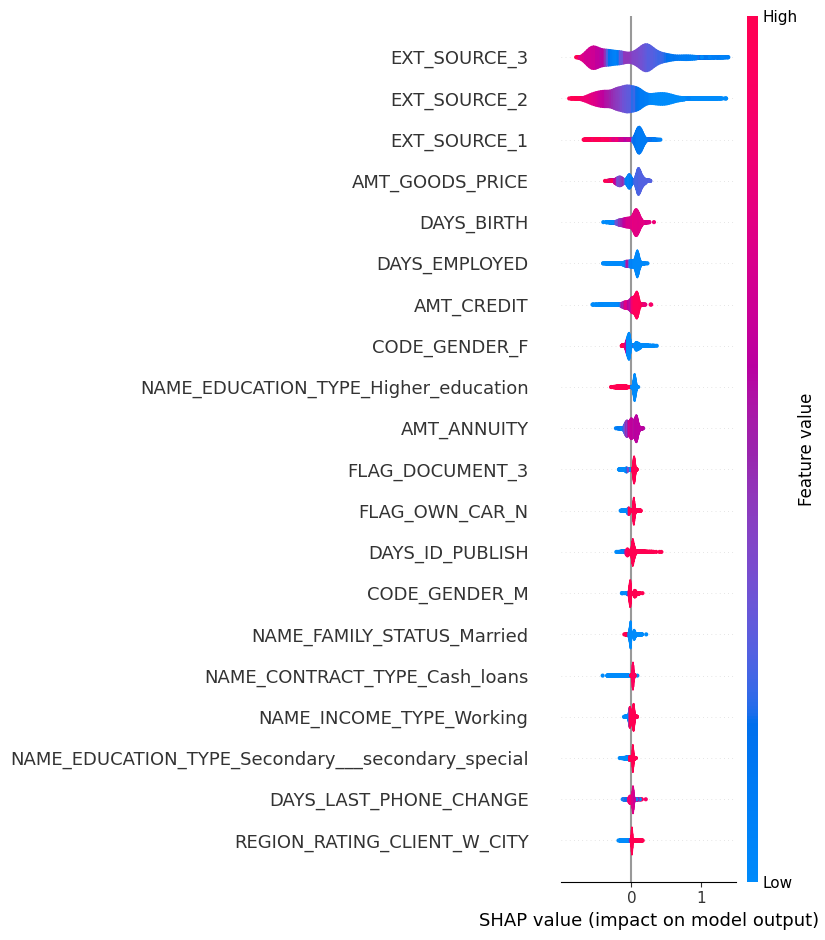

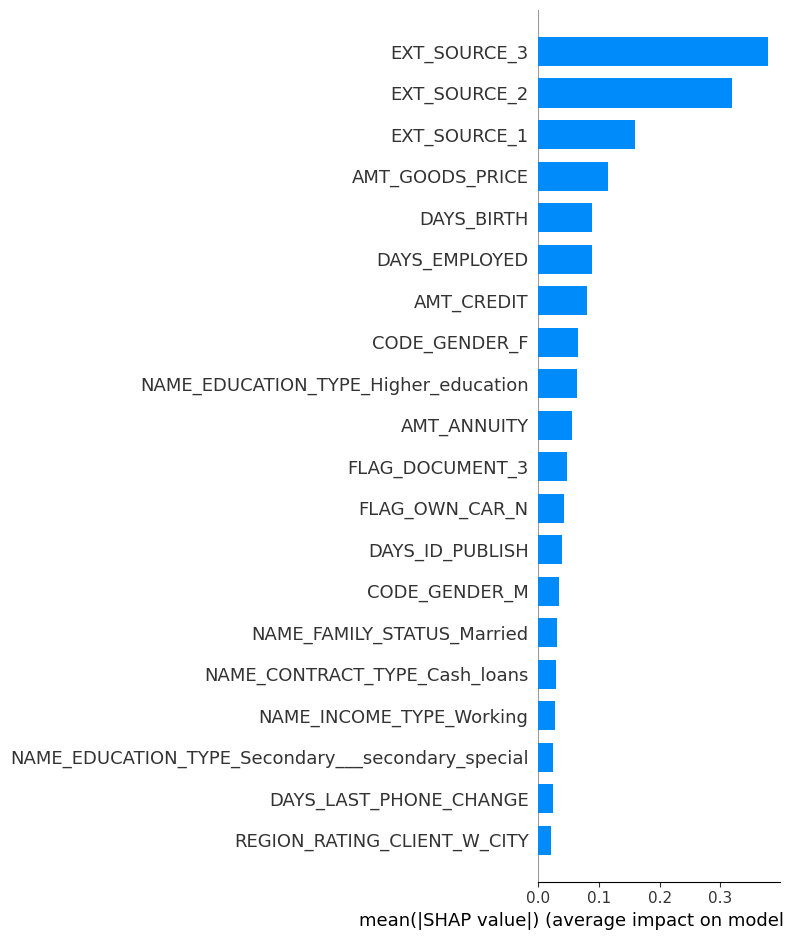

Création du graphique SHAP pour un individu (force plot)...


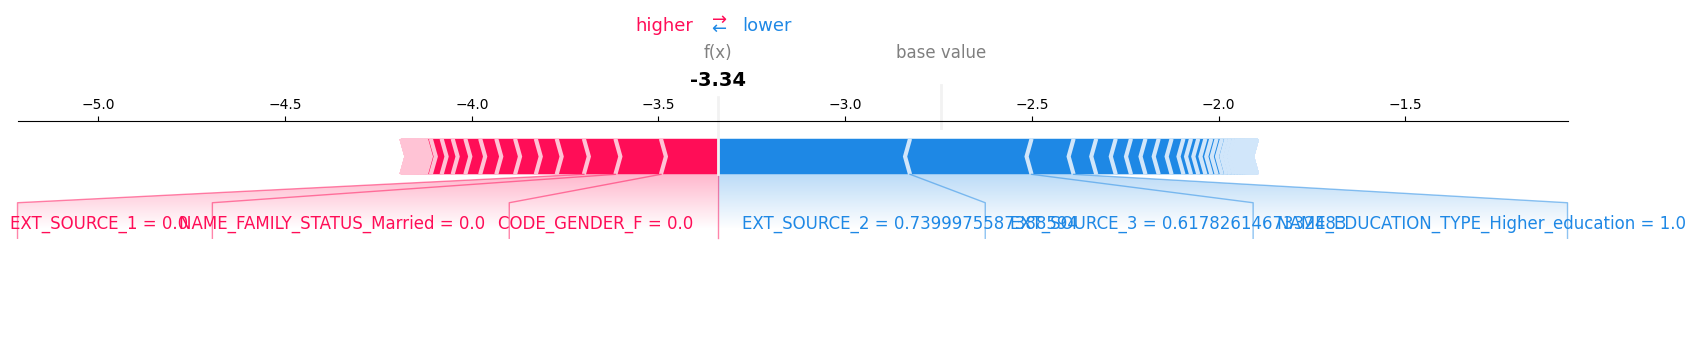

<Figure size 640x480 with 0 Axes>

Analyse SHAP (avec X_train original) - terminé en 18.33s
Exécution complète - terminé en 18.33s


In [402]:
@contextmanager
def timer(title):
    import time
    t0 = time.time()
    yield
    print(f"{title} - terminé en {time.time() - t0:.2f}s")

def analyse_shap_bal(model_file, X_test, output_dir="shap_results_no"):
    """
    Analyse SHAP pour un modèle LightGBM sauvegardé au format .pkl.
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    print("Chargement du modèle LightGBM pour SHAP...")
    model = joblib.load(model_file)  # Charger le modèle sauvegardé au format .pkl
    booster = model.booster_  # Accéder au modèle natif LightGBM

    print("Préparation des données pour SHAP...")
    # Utiliser un échantillon de X_train
    data_sample = X_test.sample(10000, random_state=42)
    print(f"Échantillon : {data_sample.shape}")

    print("Calcul des valeurs SHAP...")
    explainer = shap.TreeExplainer(booster)
    shap_values = explainer.shap_values(data_sample)

    # Vérification pour modèles binaires
    if isinstance(shap_values, list) and len(shap_values) > 1:
        shap_values = shap_values[1]

    print("Création des graphiques SHAP...")
    # Résumé SHAP (violin plot)
    plt.figure()
    shap.summary_plot(shap_values, data_sample, plot_type="violin", show=False)
    plt.savefig(os.path.join(output_dir, "shap_summary_violin.png"))
    plt.show()
    plt.close()

    # Résumé SHAP (bar plot)
    plt.figure()
    shap.summary_plot(shap_values, data_sample, plot_type="bar", show=False)
    plt.savefig(os.path.join(output_dir, "shap_summary_bar.png"))
    plt.show()
    plt.close()

    # Force plot pour un client spécifique
    print("Création du graphique SHAP pour un individu (force plot)...")
    sample_idx = 6  
    
    expected_value = explainer.expected_value[1] if isinstance(explainer.expected_value, list) else explainer.expected_value
    
    # Générer le force plot
    shap.force_plot(
        expected_value,
        shap_values[sample_idx, :],
        data_sample.iloc[sample_idx, :],
        matplotlib=True
    )
    plt.savefig(os.path.join(output_dir, f"shap_force_plot_client_{sample_idx}.png"))
    plt.show()

def main(debug=False):
    print("Chargement des données...")
    global X_test  

    model_file = "/Users/Nelly/Desktop/projet7/best modele/best_model_lgb_no.pkl"

    # Vérification si le fichier modèle existe
    if not os.path.exists(model_file):
        print(f"Erreur : le fichier du modèle '{model_file}' est introuvable. Veuillez vérifier le chemin.")
        return

    # Analyse SHAP
    print("Analyse SHAP en cours...")
    with timer("Analyse SHAP (avec X_train original)"):
        analyse_shap_bal(model_file, X_test)

if __name__ == "__main__":
    with timer("Exécution complète"):
        main()


# <span style="color:green; font-weight:bold;">Partie 5 : Data drift </span>

In [404]:
# Charger les datasets
df_preprocessed = application_train_test(nan_as_category=True)

# Séparer les données d'entraînement (TARGET non nul)
train_df = df_preprocessed[df_preprocessed['TARGET'].notnull()]

# Charger les données de test (TARGET nul)
test_df = df_preprocessed[df_preprocessed['TARGET'].isnull()]

# Charger le modèle LightGBM au format .pkl
model_file = "/Users/Nelly/Desktop/projet7/best modele/best_model_lgb_no.pkl"
if not os.path.exists(model_file):
    raise FileNotFoundError(f"Le fichier de modèle '{model_file}' est introuvable.")

print("Chargement du modèle LightGBM sauvegardé en .pkl...")
clf = joblib.load(model_file)  # Charger le modèle avec joblib

# Extraire les features du modèle
model_features = clf.booster_.feature_name()

# Vérifier que toutes les features du modèle sont présentes dans les deux datasets
valid_features = [f for f in model_features if f in train_df.columns and f in test_df.columns]

# Filtrer les datasets pour inclure uniquement les features pertinentes
train_df_filtered = train_df[valid_features]
test_df_filtered = test_df[valid_features]

# Création d'un rapport Evidently pour le Data Drift sur toutes les features
data_drift_report = Report(metrics=[DataDriftPreset()])

# Calculer le Data Drift entre les données d'entraînement et de test
print("Calcul du Data Drift sur toutes les features...")
data_drift_report.run(reference_data=train_df_filtered, current_data=test_df_filtered)

# Sauvegarder le rapport HTML
output_file = "data_drift_report_all_features.html"
data_drift_report.save_html(output_file)

print(f"Le rapport de Data Drift a été généré : {output_file}")

Échantillons d'entraînement : 307511, échantillons de test : 48744
Chargement du modèle LightGBM sauvegardé en .pkl...
Calcul du Data Drift sur toutes les features...
Le rapport de Data Drift a été généré : data_drift_report_all_features.html


In [405]:
#X_test.to_csv('/Users/Nelly/Desktop/projet 7/data/clients_data.csv', index=False)